In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


# Setup

In [2]:
# install tensorflow 2.15 since voxelmorph is not compatible with current build
import tensorflow as tf
if not tf.__version__.startswith('2.15'):
  !pip uninstall -y tensorflow
  !pip install tensorflow==2.15
# install voxelmorph
!pip install voxelmorph

2024-08-16 01:20:25.733600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import voxelmorph as vxm
import neurite as ne

import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors, patches
import numpy as np

from sklearn.model_selection import train_test_split

# Download dataset

In [4]:
# download dataset
filename = 'AbdomenCTCT.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/32WaSRaTnFk2JeT/download/AbdomenCTCT.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [5]:
def load_data(jsonData, dataFolderPath, training_or_test, filterString='0001'):
    images = []
    labels = []
    for sample in jsonData[training_or_test]:
        image = nib.load(dataFolderPath + sample['image'].removeprefix('.').replace(".csv",".nii.gz")).get_fdata()
        images.append(image)
        if training_or_test == 'training':
          label = nib.load(dataFolderPath + sample['label'].removeprefix('.').replace(".csv",".nii.gz")).get_fdata()
          labels.append(label)

    return np.array(images), np.array(labels)

In [6]:
# load data
with open('./AbdomenCTCT/AbdomenCTCT_dataset.json', 'r') as file:
  data_json = json.load(file)
dataFolder = './AbdomenCTCT'
images_raw, labels_raw = load_data(data_json, dataFolder, 'training')

In [7]:
images_raw.shape

(30, 192, 160, 256)

In [8]:
labels_raw.shape

(30, 192, 160, 256)

# Preprocess data

In [9]:
# normalize images
images_normalized = (images_raw - np.min(images_raw)) / (np.max(images_raw) - np.min(images_raw))

# rotate tensor
images_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in images_normalized])
labels_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in labels_raw])

# swap and flip axes
images = np.swapaxes(images_rotated, 1, 2)[:, ::-1, :, :]
labels = np.swapaxes(labels_rotated, 1, 2)[:, ::-1, :, :]

# prepare tensor just with organs
organs = np.zeros_like(images)
organs[labels > 0] = images[labels > 0]

In [10]:
del images_raw
del labels_raw
del images_normalized
del images_rotated
del labels_rotated

(-0.5, 191.5, 255.5, -0.5)

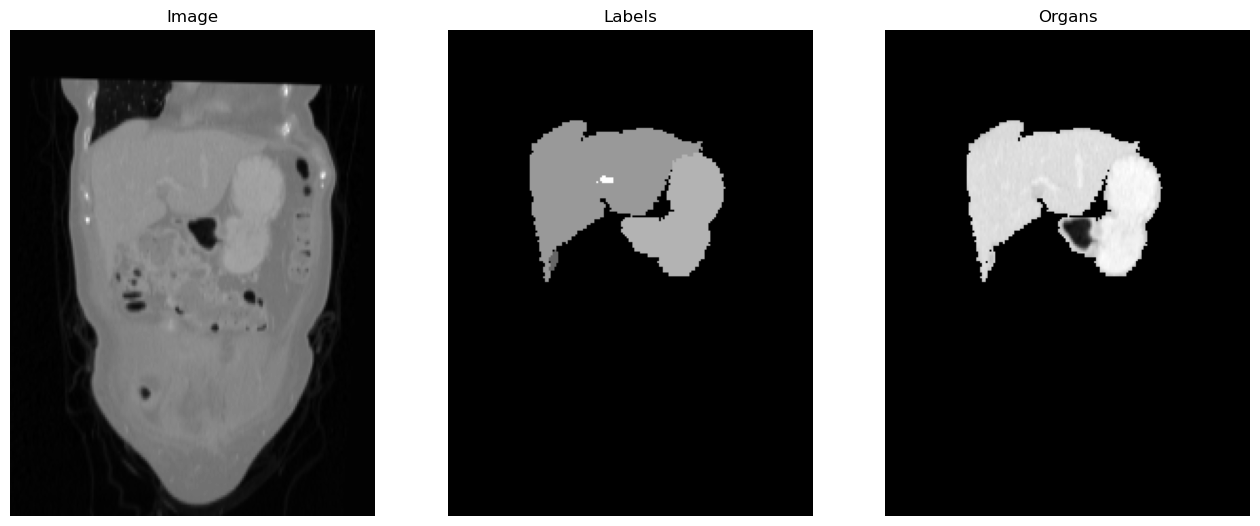

In [11]:
# preview data
img = 0
depth = 40

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(images[img,depth],cmap='gray')
ax0.set_title("Image")
ax0.axis("off")
ax1.imshow(labels[img,depth], cmap='gray')
ax1.set_title("Labels")
ax1.axis("off")
ax2.imshow(organs[img,depth], cmap='gray')
ax2.set_title("Organs")
ax2.axis("off")

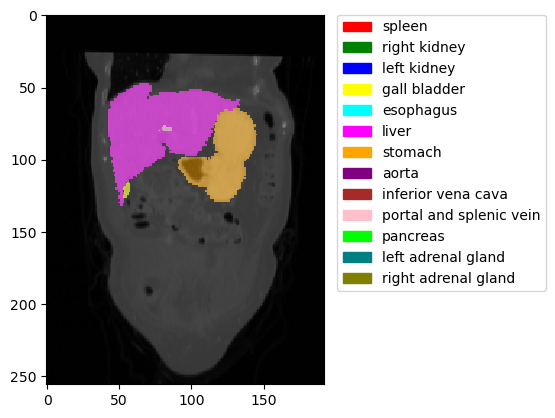

In [12]:
# setup colormap
cmap = colors.ListedColormap([
    'black', 'red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange',
    'purple', 'brown', 'pink', 'lime', 'teal', 'olive'
])
norm = colors.BoundaryNorm(boundaries=np.arange(-0.5, 14, 1), ncolors=14)

# view image
plt.imshow(images[img,depth], cmap='gray', interpolation='none')

# view colors
plt.imshow(labels[img,depth], cmap=cmap, norm=norm, alpha=0.5, interpolation='none')

# setup legend
legend_labels = {
    1: "spleen",
    2: "right kidney",
    3: "left kidney",
    4: "gall bladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior vena cava",
    10: "portal and splenic vein",
    11: "pancreas",
    12: "left adrenal gland",
    13: "right adrenal gland"
}

# view rectangles in legend
patches_list = [
    patches.Patch(color=cmap(i), label=legend_labels[i])
    for i in range(1, 14)
]

# view legend
plt.legend(handles=patches_list, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [13]:
# split dataset
training_organs, test_organs = train_test_split(organs, test_size=0.2, random_state=10)

In [14]:
del images
del labels
del organs

In [15]:
training_organs.shape

(24, 160, 256, 192)

In [16]:
test_organs.shape

(6, 160, 256, 192)

# Define Model

In [17]:
# define the input shapes
inshape = training_organs.shape[1:]
nb_features = (
    (16, 32, 32), # encoder-channels
    (32, 32, 16, 16) # decoder-channels
    )
# build model using VxmDense
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

# Load weights

In [18]:
vxm_model.load_weights('models/AbdomenCTCT_organs_model.h5')
                       
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 160, 256, 192, 1), (None, 160, 256, 192, 1)
output shape: (None, 160, 256, 192, 1), (None, 160, 256, 192, 3)


# Test registration

In [19]:
# define a data generator
def test_data_generator(data):
    while True:
        idx1 = np.random.randint(0, data.shape[0], size=1)
        idx2 = np.random.randint(0, data.shape[0], size=1)
        while idx2 == idx1:
            idx2 = np.random.randint(0, data.shape[0], size=1)

        fixed_image = data[idx1, ..., np.newaxis]
        moving_image = data[idx2, ..., np.newaxis]

        yield fixed_image, moving_image

In [20]:
# define validation generator
test_generator = test_data_generator(test_organs)

In [21]:
# get test sample
test_input = next(test_generator)

In [22]:
# perform prediction
test_pred = tuple(vxm_model.predict(test_input))

1/1 [==============================] - 8s 8s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


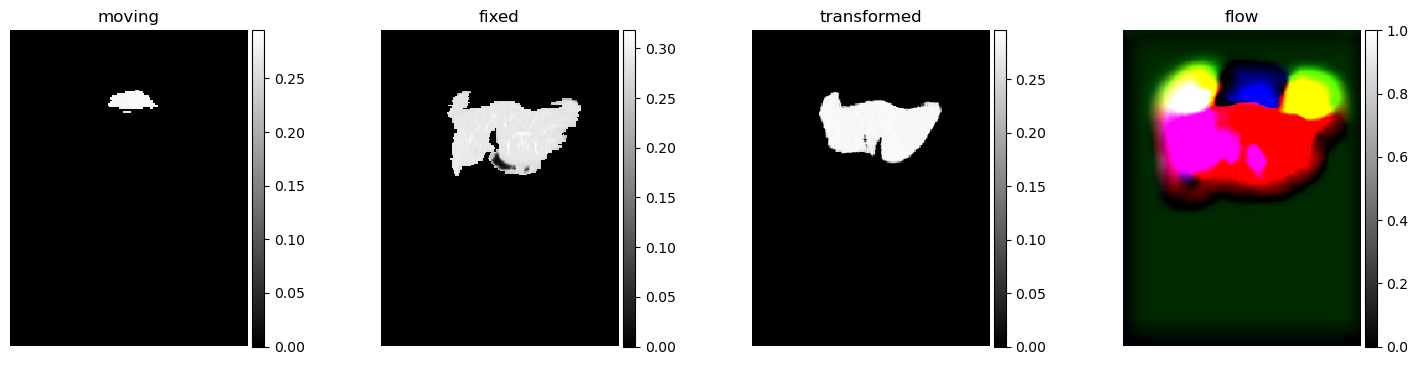

In [23]:
# view result
images = [img[0, depth] for img in test_input + test_pred]
titles = ['moving', 'fixed', 'transformed', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# Evaluation

In [24]:
def dice_score_tf(y_true, y_pred, smooth=1e-6):
    binary_y_true = tf.cast(y_true > 0, tf.float32)
    binary_y_pred = tf.cast(y_pred > 0, tf.float32)

    y_true_flat = tf.reshape(binary_y_true, [-1])
    y_pred_flat = tf.reshape(binary_y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    dice = (2. * intersection + smooth) / (union + smooth)
    return float(dice)


In [25]:
n = test_organs.shape[0]
count = 0
dice = 0
mse = 0
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        else:
            count += 1
            test_input = np.array([test_organs[i, ..., np.newaxis]]), np.array([test_organs[j, ..., np.newaxis]])
            test_pred = tuple(vxm_model.predict(test_input))
            dice += dice_score_tf(test_input[1][0], test_pred[0][0])
            mse += np.mean(np.square(test_input[1][0] - test_pred[0][0]))

1/1 [==============================] - 10s 10s/step


In [26]:
print("Dice: " + str(dice/count))
print("MSE: " + str(mse/count))

Dice: 0.8106100996335347
MSE: 0.0012974478527086883
